In [1]:
import numpy as np
import pandas as pd
import nba_on_court as noc
import seaborn as sns
from sklearn.linear_model import RidgeCV

pd.set_option('display.max_columns', 500)

### Model Fitting

This code is essentially the same code as `fit_ridge_odrapm.qmd`, except that this code removes the signed intercept from the model. I'm much better at data manipulation in Python than R.

In [2]:
design  = pd.read_csv('../../design_matrices/odrapm_design.csv.gz', index_col=0).drop('0', axis=1)
pm      = pd.read_csv('../../data/processed_data_2022.csv', index_col=0)['PM']
players = design.columns[::2].astype(int).to_list()

In [3]:
model = RidgeCV(
    alphas=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 500, 1000, 1500, 2000, 2500, 3000],
    fit_intercept=False
).fit(design, pm)

coefs = model.coef_

In [4]:
orapm = coefs[::2]
drapm = coefs[1::2]

results = pd.DataFrame({
    'Player'        : noc.players_name(players),
    'ORAPM'         : orapm,
    'DRAPM'         : drapm,
    'RAPM'          : orapm - drapm,
    'Average PM'    : np.empty(len(orapm)) # to be filled
})

In [5]:
data = pd.read_csv('../../data/processed_data_2022.csv', index_col=0) 
indicators = pd.read_csv('../../design_matrices/odrapm_design.csv.gz', usecols=range(2, 2 * (len(players)+1)))

games = pd.unique(data['GAME_ID'])

# calculate average pm for each player
# this is definitely not the most efficient way to do this
# but i'm too lazy to figure it out
for i in range(len(players)):
    onpm = 0
    offpm = 0
    total_stints = 0
    for game in games:
        bools: list[bool] = data['GAME_ID'] == game # specifying the data type for my IDE
        if not np.any(bools): # if the player isn't in the game
            continue
        current_data, current_indic = data[bools], indicators[bools]
        
        sign = np.sign(current_indic.sum())
        on_indicators = current_indic.iloc[:, 2*i] + current_indic.iloc[:, 2*i+1]
        off_indicators = ((~on_indicators.astype(bool)).astype(int)).mul(sign) # in case we need to swap -1, 0 instead of 1, 0
        
        onpm += (on_indicators * current_data['PM']).sum()
        offpm += (off_indicators * current_data['PM']).sum()
        total_stints += len(current_data)

    results.at[i, 'Average PM'] = (onpm - offpm) / total_stints

In [6]:
results.sort_values(by=['Average PM'], ascending=False, inplace=True)

results.to_csv('../../results/no_intercept_results.csv')

In [14]:
results.sort_values(by=['RAPM'], ascending=False).head(10)

,Player,ORAPM,DRAPM,RAPM,Average PM
170,Anthony Edwards,0.245827,-0.151255,0.397082,-0.000740
123,Jalen Brunson,0.215274,-0.151036,0.366310,0.001956
157,De'Andre Hunter,0.191546,-0.163801,0.355347,-0.000846
175,Saddiq Bey,0.095063,-0.257586,0.352649,-0.001850
0,LeBron James,0.157884,-0.178907,0.336791,0.001427
67,Clint Capela,0.155399,-0.173115,0.328515,-0.001216
75,Devin Booker,0.143425,-0.168829,0.312254,-0.001850
85,Malik Beasley,0.138475,-0.167234,0.305710,-0.000952
93,Gary Payton II,0.131098,-0.171215,0.302314,-0.002115
146,Duncan Robinson,0.186679,-0.108008,0.294687,0.003542


<Axes: xlabel='RAPM', ylabel='Average PM'>

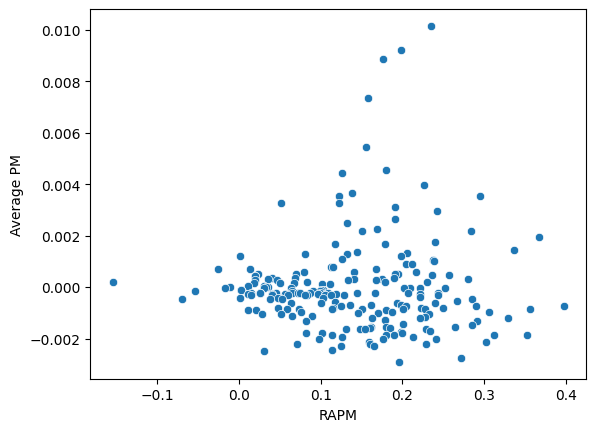

In [7]:
sns.scatterplot(x=results['RAPM'], y=results['Average PM'])

In [8]:
np.corrcoef(results['RAPM'], results['Average PM'])

array([[1.        , 0.03002289],
       [0.03002289, 1.        ]])

1